In [1]:
import pandas as pd       
import numpy as np
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model


import cv2

import warnings
warnings.filterwarnings('ignore')

import random
import os
import glob
from numpy.random import seed
seed(42)

random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

from tensorflow.random import set_seed
set_seed(42)

In [2]:
IMG_SIZE = 224
BATCH = 6
SEED = 42

In [3]:
main_path = r"D:\data set\new knee data\new knee data"


train_path = os.path.join(main_path,"train")

train_normal = glob.glob(train_path+"/Normal/*.png")
train_Osteoarthritis= glob.glob(train_path+"/Osteoarthritis/*.png")



In [4]:
train_list = [x for x in train_normal]
train_list.extend([x for x in train_Osteoarthritis])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Osteoarthritis']*len(train_Osteoarthritis)]), columns = ['class'])
df_train['image'] = [x for x in train_list]


In [5]:
df_train

,class,image
0,Normal,D:\data set\new knee data\new knee data\train/...
1,Normal,D:\data set\new knee data\new knee data\train/...
2,Normal,D:\data set\new knee data\new knee data\train/...
3,Normal,D:\data set\new knee data\new knee data\train/...
4,Normal,D:\data set\new knee data\new knee data\train/...
...,...,...
925,Osteoarthritis,D:\data set\new knee data\new knee data\train/...
926,Osteoarthritis,D:\data set\new knee data\new knee data\train/...
927,Osteoarthritis,D:\data set\new knee data\new knee data\train/...
928,Osteoarthritis,D:\data set\new knee data\new knee data\train/...


In [6]:
trace = go.Pie(labels = ['Osteoarthritis', 'Normal'], values = df_train['class'].value_counts(), 
               textfont=dict(size=15), opacity = 0.8,
               marker=dict(colors=['lightskyblue','gold'], 
                           line=dict(color='#000000', width=1.5)))


layout = dict(title =  'Distribution of class variable in train dataset')
           
fig = dict(data = [trace], layout=layout)
py.iplot(fig)


Train Set - Normal


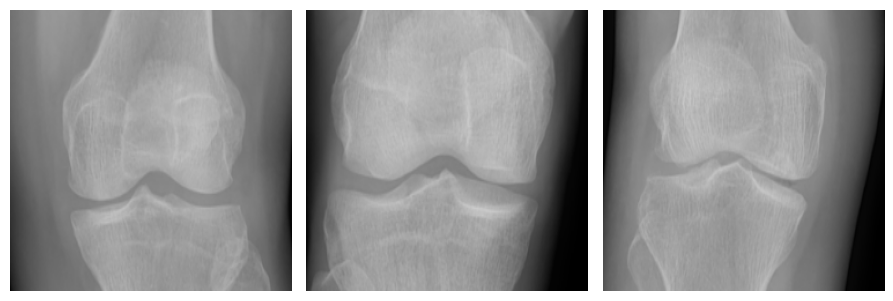

Train Set - Osteoarthritis


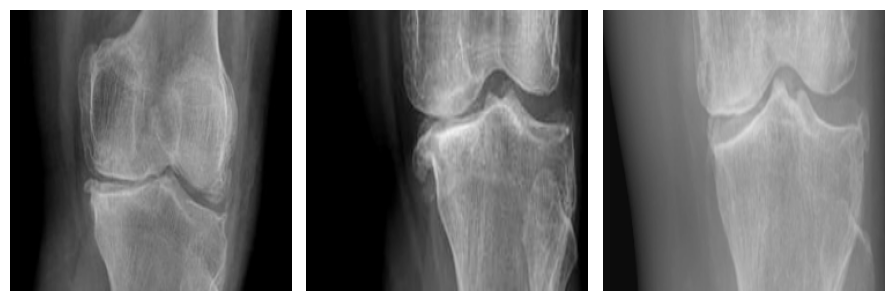

In [7]:
Osteoarthritis = df_train[(df_train['class'] == 'Osteoarthritis')]
Normal = df_train[(df_train['class'] == 'Normal')]

print('Train Set - Normal')

plt.figure(figsize=(12,12))

for i in range(0, 3):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_normal[i])
    img = cv2.resize(img, (244,244))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()


print('Train Set - Osteoarthritis')

plt.figure(figsize=(12,12))

for i in range(0, 3):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_Osteoarthritis[i])
    img = cv2.resize(img, (244,244))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

In [8]:
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = SEED, stratify = df_train['class'])
train_df, test_df = train_test_split(train_df, test_size = 0.10, random_state = SEED, stratify = train_df['class'])

In [9]:
train_datagen = ImageDataGenerator(rescale=1/255.,zoom_range =0.1,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0,brightness_range=[0.4,1.5],horizontal_flip=True, vertical_flip=True)

val_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = val_datagen.flow_from_dataframe(test_df,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

Found 669 validated image filenames belonging to 2 classes.
Found 186 validated image filenames belonging to 2 classes.
Found 75 validated image filenames belonging to 2 classes.


In [10]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 1e-7,                                
    cooldown = 0,                               
    verbose = 1
) 

In [11]:
base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)




def get_pretrained():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    x = base_model(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model
keras.backend.clear_session()

model_pretrained = get_pretrained()
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=5e-5), metrics='binary_accuracy')

model_pretrained.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [12]:
history = model_pretrained.fit(ds_train,
          batch_size = BATCH, epochs = 50,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/50
111/111 [==============================] - 75s 524ms/step - loss: 0.4474 - binary_accuracy: 0.8027 - val_loss: 0.5080 - val_binary_accuracy: 0.7849 - lr: 5.0000e-05
Epoch 2/50
111/111 [==============================] - 51s 454ms/step - loss: 0.2289 - binary_accuracy: 0.9058 - val_loss: 0.1411 - val_binary_accuracy: 0.9624 - lr: 5.0000e-05
Epoch 3/50
111/111 [==============================] - 51s 454ms/step - loss: 0.2447 - binary_accuracy: 0.8999 - val_loss: 0.6302 - val_binary_accuracy: 0.8011 - lr: 5.0000e-05
Epoch 4/50
111/111 [==============================] - 51s 457ms/step - loss: 0.1833 - binary_accuracy: 0.9283 - val_loss: 0.0728 - val_binary_accuracy: 0.9785 - lr: 5.0000e-05
Epoch 5/50
111/111 [==============================] - 51s 457ms/step - loss: 0.1649 - binary_accuracy: 0.9417 - val_loss: 0.1001 - val_binary_accuracy: 0.9624 - lr: 5.0000e-05
Epoch 6/50
111/111 [==============================] - 51s 455ms/step - loss: 0.1376 - binary_accuracy: 0.9522 - val_loss

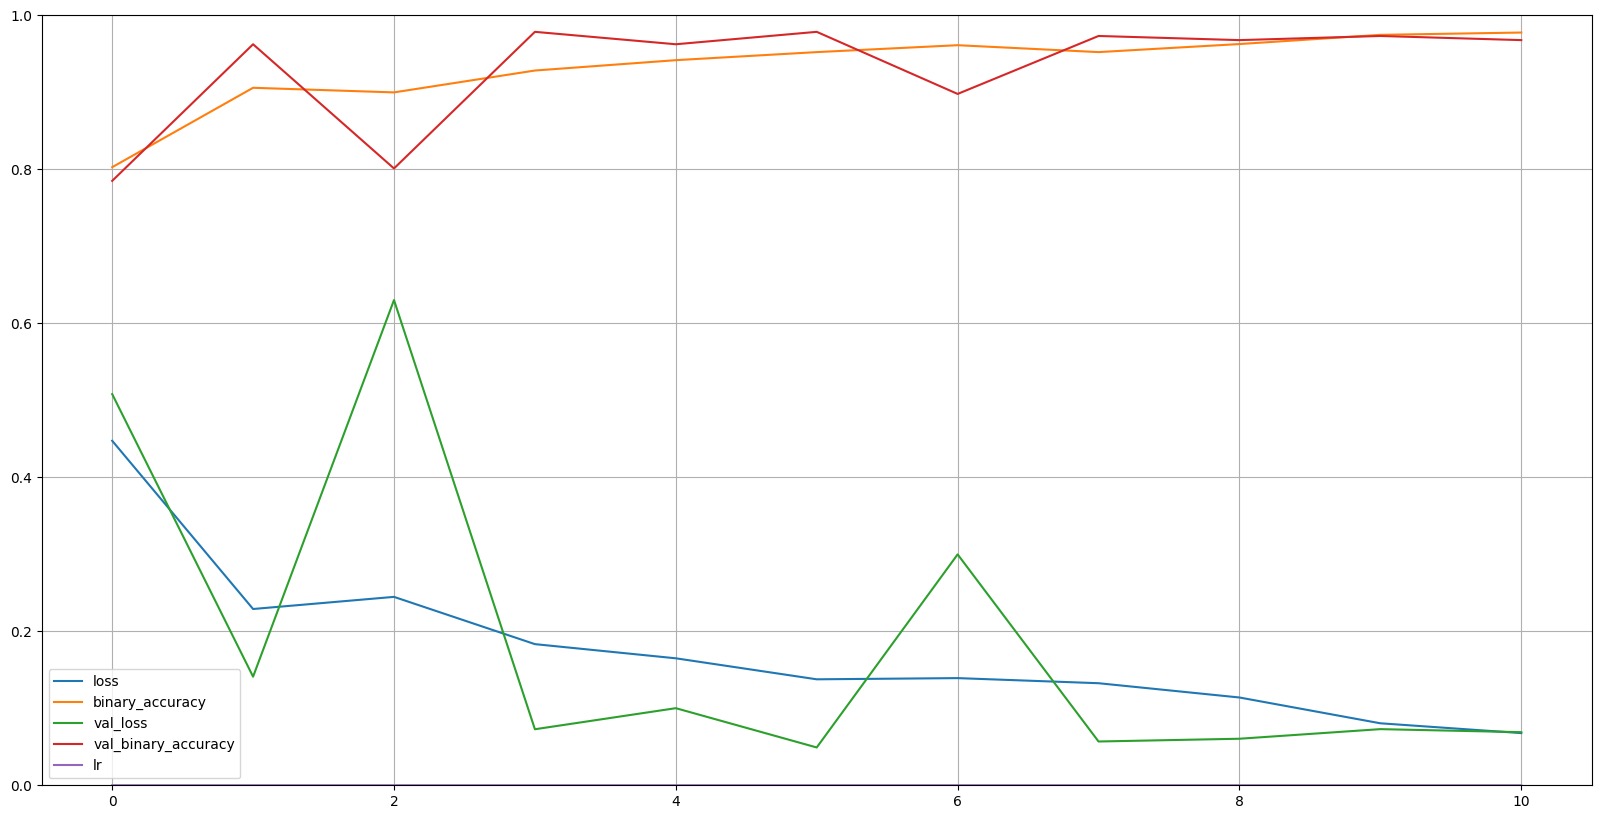

In [13]:
pd.DataFrame(history.history).plot(figsize=(20,10))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [14]:
score = model_pretrained.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.04909711331129074
Val accuracy: 0.9784946441650391


In [15]:
score = model_pretrained.evaluate(ds_test, steps = len(test_df), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.03772105276584625
Test accuracy: 0.9866666793823242
